# Makemore (Part 4)
Here we manually implement backpropagation for a multilayer perceptron, using tensors this time, with the aim of understanding it better.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('/media/eric/D/datasets/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
												# this is the ubiased estimate (1/n would be biased estimate)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3460, grad_fn=<NegBackward0>)

In [9]:
probs.shape, counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

**Exercise 1**: backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one:

First, `dloss` is of course 1 (as changing `loss` always influences how `loss` changes by a factor of 1) so we skip it.  

Next, we want to know `dloss/dlogprobs`, the derivative of `logprobs` with respect to `loss` (how a change in `logprobs` influences the `loss`). `logprobs` is of shape 32x27 (32 examples and 27 outputs). However, only one output (the correct one) of each example influences the loss, so these will have non-zero gradients, the rest will be 0.

Now, `loss = -logprobs[range(n), Yb].mean()`, so it's like the mean of a 1D vector: `f=-(a + b + c)/3=-1/3a -1/3b -1/3c`. For example, `df/da = -1/3`. So, for our `dlogprobs` tensor, we have to set everything to 0.0 except those indexed that must be -1/n.

In [10]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


Local derivative `dlogprobs/dprobs` is easy: `1/probs`. But as we want `dloss/dprobs`, we multiply by `dlogprobs` as by **chainrule**. Observe what's happening: if probs is close to 1, characters are predicted correctly, so 1/1 = 1 and the gradient passes through, but if incorrectly, 1/0.1 > 1. So intuitively this operation is boosting the gradients of the examples with low probability assigned.

In [11]:
dprobs = (1 / probs) * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


For `dcounts_sum_inv`, careful because in `probs = counts * counts_sum_inv`, `counts` has shape 32x27 and `counts_sum_inv` has shape 32x1, so this is actually two operations: broadcasting and then element-wise multiplication.  
So first we backpropagate through multiplication and do chainrule: `_dcounts_sum_inv = counts * dprobs`.  
For broadcasting, we have that the values of one vector are being used multiple times. We know from micrograd that this implies that the gradients will be summed up, so: `dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)`.

In [12]:
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [13]:
counts_sum_inv.shape, dcounts_sum_inv.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [14]:
dcounts_sum = -1*counts_sum**-2 * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


`counts` is used twice, so we have to compute first its contribution to `probs`: `_dcounts = counts_sum_inv * dprobs`.  
And then to `counts_sum = counts.sum(1, keepdims=True)`. `counts_sum` is just a sum of all elements in each row of `counts`, so the derivative of each element of `counts_sum` with respect to each element of the corresponding row in `counts` is 1.0.

In [15]:
dcounts = counts_sum_inv * dprobs # 32x27 = 32x1 * 32x27
# dcounts += torch.ones_like(counts) * dcounts_sum
dcounts += dcounts_sum # 32x27 += 32x27 * 32x1
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
# dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits = counts * dcounts # more efficient
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


If we print `dlogit_maxes`, we would see the gradients are almost 0.0. This is because the operation `norm_logits = logits - logit_maxes` is only for numerical stability and shouldn't affect the final result at all.

In [17]:
# dlogit_maxes = (-torch.ones_like(logits) * dnorm_logits).sum(dim=1, keepdim=True)
dlogit_maxes = -dnorm_logits.sum(dim=1, keepdim=True) # more efficient
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [19]:
# dlogits = torch.ones_like(logits) * dnorm_logits
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


In [21]:
h.shape, W2.shape, dlogits.shape

(torch.Size([32, 64]), torch.Size([64, 27]), torch.Size([32, 27]))

In [22]:
dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


In [23]:
b2.shape, dlogits.shape

(torch.Size([27]), torch.Size([32, 27]))

In [24]:
# db2 = (torch.ones_like(logits) * dlogits).sum(dim=0, keepdim=True)
db2 = dlogits.sum(dim=0, keepdim=True)
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
# dhpreact = (1 - torch.tanh(hpreact) ** 2) * dh
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [26]:
emb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [27]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
dcounts_sum = -1*counts_sum**-2 * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += dcounts_sum 
dnorm_logits = counts * dcounts
dlogit_maxes = -dnorm_logits.sum(dim=1, keepdim=True)
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0, keepdim=True)
dhpreact = (1.0 - h ** 2) * dh
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnbias = dhpreact.sum(dim=0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = 1/(n-1) * dbnvar
dbndiff = bnvar_inv * dbnraw
dbndiff += 2*bndiff * dbndiff2
dbnmeani = -dbndiff.sum(dim=0, keepdim=True)
dhprebn = dbndiff.clone()
dhprebn += 1/n*dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(dim=0, keepdim=True)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j] # += in case of multiple occurences

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw  

**Exercise 2**: backprop through cross_entropy but all in one go to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out.

In [28]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3460135459899902 diff: 0.0


In [29]:
# backward pass

dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp("logits", dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.752088665962219e-09


Let's explore `logits` and `dlogits`:

In [30]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [31]:
F.softmax(logits, 1)[0]

tensor([0.0677, 0.1005, 0.0195, 0.0503, 0.0186, 0.0798, 0.0242, 0.0363, 0.0183,
        0.0297, 0.0347, 0.0397, 0.0385, 0.0260, 0.0337, 0.0138, 0.0096, 0.0187,
        0.0157, 0.0547, 0.0449, 0.0214, 0.0266, 0.0721, 0.0592, 0.0262, 0.0199],
       grad_fn=<SelectBackward0>)

In [32]:
dlogits[0] * n # multiply by n for us to scale and interpret it better

tensor([ 0.0677,  0.1005,  0.0195,  0.0503,  0.0186,  0.0798,  0.0242,  0.0363,
        -0.9817,  0.0297,  0.0347,  0.0397,  0.0385,  0.0260,  0.0337,  0.0138,
         0.0096,  0.0187,  0.0157,  0.0547,  0.0449,  0.0214,  0.0266,  0.0721,
         0.0592,  0.0262,  0.0199], grad_fn=<MulBackward0>)

We can see they are equal to the previous probability in forward pass, but the correct index is subtracted by 1.

In [33]:
dlogits[0].sum()

tensor(3.7253e-09, grad_fn=<SumBackward0>)

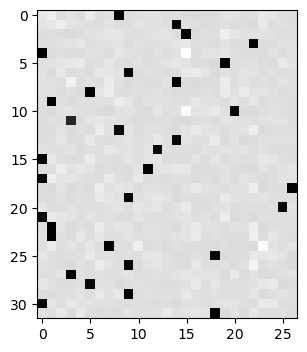

In [34]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

32 examples x 27 characters. Black squares are the positions of the correct indices (where we subtracted 1). We can interpret this as the neural net, when trainig, will have a force pulling up the probabilities of the correct indices, and pulling down the rest. And the amount of pull up and down is equalized (the sum is 0, as seen above). If we have an index whose logit is too overconfidently wrong, it will be pulled down more than the rest.

**Exercise 3**: backprop through batchnorm but all in one go to complete this challenge look at the mathematical expression of the output of batchnorm, take the derivative w.r.t. its input, simplify the expression, and just write it out

In [35]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [36]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) 

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


**Exercise 4**: putting it all together!

In [45]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 10 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 100000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

	# kick off optimization
	for i in range(max_steps):

		# minibatch construct
		ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
		Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

		# forward pass
		emb = C[Xb] # embed the characters into vectors
		embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
		# Linear layer
		hprebn = embcat @ W1 + b1 # hidden layer pre-activation
		# BatchNorm layer
		# -------------------------------------------------------------
		bnmean = hprebn.mean(0, keepdim=True)
		bnvar = hprebn.var(0, keepdim=True, unbiased=True)
		bnvar_inv = (bnvar + 1e-5)**-0.5
		bnraw = (hprebn - bnmean) * bnvar_inv
		hpreact = bngain * bnraw + bnbias
		# -------------------------------------------------------------
		# Non-linearity
		h = torch.tanh(hpreact) # hidden layer
		logits = h @ W2 + b2 # output layer
		loss = F.cross_entropy(logits, Yb) # loss function

		# backward pass
		for p in parameters:
			p.grad = None
		# loss.backward() # use this for correctness comparisons, delete it later!

		# manual backprop! #swole_doge_meme
		# -----------------
		dlogits = F.softmax(logits, 1)
		dlogits[range(n), Yb] -= 1
		dlogits /= n
		# 2nd layer backprop
		dh = dlogits @ W2.T
		dW2 = h.T @ dlogits
		db2 = dlogits.sum(0)
		# tanh
		dhpreact = (1.0 - h**2) * dh
		# batchnorm backprop
		dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
		dbnbias = dhpreact.sum(0, keepdim=True)
		dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
		# 1st layer
		dembcat = dhprebn @ W1.T
		dW1 = embcat.T @ dhprebn
		db1 = dhprebn.sum(0)
		# embedding
		demb = dembcat.view(emb.shape)
		dC = torch.zeros_like(C)
		for k in range(Xb.shape[0]):
			for j in range(Xb.shape[1]):
				ix = Xb[k,j]
				dC[ix] += demb[k,j]
		grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
		# -----------------

		# update
		lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
		for p, grad in zip(parameters, grads):
			#p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
			p.data += -lr * grad # new way of swole doge TODO: enable

		# track stats
		if i % 10000 == 0: # print every once in a while
			print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
		lossi.append(loss.log10().item())

		# if i >= 100: # TODO: delete early breaking when you're ready to train the full net
		# 	break

897
      0/ 100000: 3.3157
  10000/ 100000: 2.4742
  20000/ 100000: 2.4488
  30000/ 100000: 2.3257
  40000/ 100000: 2.2248
  50000/ 100000: 2.2843
  60000/ 100000: 2.5610
  70000/ 100000: 2.3813
  80000/ 100000: 2.2345
  90000/ 100000: 2.2138


In [42]:
# useful for checking your gradients (freeze "with torch.no_grad():" and unfreeze "loss.backward()")
# for p,g in zip(parameters, grads):
# 	cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


In [46]:
# calibrate the batch norm at the end of training (we didn't do it while running)

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [47]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.3031163215637207
val 2.3007500171661377


In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kmyan.
seel.
ndhayah.
rethrelendrami.
aderedielii.
shi.
jelleigin.
ananar.
kayzioh.
kalin.
shubergiaghies.
kin.
reellionn.
pulanu.
zey.
dariyah.
fael.
ylay.
myannyan.
